In [4]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import spacy
import os
import pickle

In [5]:
data_path = 'Data/first_data_prepared.pickle'

In [6]:
with open(data_path, 'rb') as file_:
    data_ = pickle.load(file_)

In [7]:
#train
X_tra = data_['X_tra']
y_tra= data_['y_tra']
#valid
X_val = data_['X_val']
y_val= data_['y_val']
#test
X_test = data_['X_test']
y_test= data_['y_test']

stopwords = data_['stopwords']

In [8]:
del data_

In [72]:
y_tra

array([0., 0., 1., ..., 0., 0., 0.])

In [74]:
y_tra = keras.utils.to_categorical(y_tra)

In [75]:
y_val = keras.utils.to_categorical(y_val)

# TF HUB

In [76]:
from keras import backend as K

In [77]:
import tensorflow_hub as hub
import tensorflow as tf
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.regularizers import l2

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [78]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [79]:
input_text = Input(shape=(1,), dtype="string")
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(embedding)
pred = Dense(3, activation='sigmoid')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________


In [81]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_tra, y_tra, epochs=3, batch_size=32, validation_data=( X_val, y_val))
    model.save_weights('./elmo-model.h5')


Train on 4988 samples, validate on 1248 samples
Epoch 1/3
4988/4988 [==============================] - 33s 7ms/step - loss: 0.3867 - acc: 0.8982 - val_loss: 0.3271 - val_acc: 0.8980
Epoch 2/3
4988/4988 [==============================] - 31s 6ms/step - loss: 0.2928 - acc: 0.9057 - val_loss: 0.3113 - val_acc: 0.9030
Epoch 3/3
4988/4988 [==============================] - 31s 6ms/step - loss: 0.2610 - acc: 0.9124 - val_loss: 0.2796 - val_acc: 0.8982


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [83]:
hist = pd.DataFrame(history.history)

W0523 14:22:04.472196 140552973475968 legend.py:1282] No handles with labels found to put in legend.


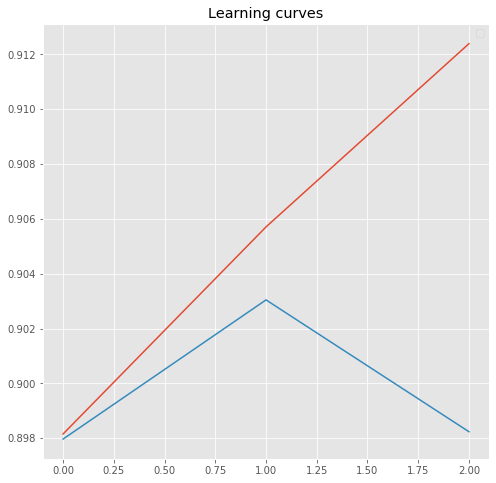

In [84]:
plt.figure(figsize=(8, 8))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.title("Learning curves")
plt.legend()
plt.show()

In [85]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(X_test, batch_size=32)

In [92]:
np.argmax(predicts, axis=1)

array([0, 1, 0, ..., 0, 1, 0])

In [93]:
model_preds = np.argmax(predicts, axis=1)

In [95]:
len(model_preds)

1560

In [99]:
y_test

array([0., 1., 0., ..., 0., 1., 0.])

In [101]:
from sklearn.metrics import f1_score
f1_score(y_test,model_preds, average='weighted')

0.8615908662382022